# Computer Vision Lab - Part II

In these lab exercises, you'll learn
* how convnets can **capture large-scale visual features** by stacking layers
* how to **create own base** for a simple image classification problem -- instead of using a pre-trained base
* how to **augment your image data** by appropriate transformation of images



---
# 1. The Receptive Field

Trace back all the connections from some neuron and eventually you reach the input image. All of the input pixels a neuron is connected to is that neuron's **receptive field**. The receptive field just tells you which parts of the input image a neuron receives information from.

As we've seen, if your first layer is a convolution with $3 \times 3$ kernels, then each neuron in that layer gets input from a $3 \times 3$ patch of pixels (except maybe at the border).

What happens if you add another convolutional layer with $3 \times 3$ kernels? Consider this next illustration:

<figure>
<img src="https://i.imgur.com/HmwQm2S.png" alt="Illustration of the receptive field of two stacked convolutions." width=250>
</figure>

Now trace back the connections from the neuron at top and you can see that it's connected to a $5 \times 5$ patch of pixels in the input (the bottom layer): each neuron in the $3 \times 3$ patch in the middle layer is connected to a $3 \times 3$ input patch, but they overlap in a $5 \times 5$ patch. So that neuron at top has a $5 \times 5$ receptive field.

[ if you go directly then there is  25 parameters, but now only 9 + 9 parameters = 18 parameters...... so it is better to go 5x5 3x3 3x3 than 5x5 to 1x1 ----- 

## 1) Growing the Receptive Field

### Q: *Now, if you added a third convolutional layer with a `(3, 3)` kernel, what receptive field would its neurons have?*

Please explain your answer in the empty cell below.

Answer:  The bottom layer will have 7x7 matrix. Then the trainable parameters will become 9+9+9 which means 27 parameters, thus the 5x5 will be better as we wwill only have 25 trainable parameters. Thus it will be more optimial. However with extra layers maybe we can capture more details from the image layers. 


So why stack layers like this? This stacking-layers trick is one of the ways convnets are able to create large receptive fields without increasing the number of parameters too much. You'll see how to do this yourself in the next exercise!

## Take-Away

This exercise ends our discussion of feature extraction. Hopefully, having completed this exercise and the exercises in the previous lab, you've gained some intuition about how the process works and why typical choices for its implementation are often good ones.

In the next exercise, you'll learn how to compose the `Conv2D` and `MaxPool2D` layers to build your own convolutional networks from scratch.

---
# 2. Custom Convnets

In these exercises, you'll build a custom convnet with performance competitive to the initial VGG16 model from lecture.

Get started by running the code cell below.

In [4]:
!wget -O data.zip https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
!unzip -o data.zip

--2023-04-27 20:34:29--  https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip [following]
--2023-04-27 20:34:30--  https://www.dropbox.com/s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc254ba634d189ed0b8f8dbf062a.dl.dropboxusercontent.com/cd/0/get/B69rFThCbWW5QTUJRxB7sQNcAMpMZzrjMc-byNjrLsXsZb0mQ9B7-tDwzwmOdoFlOqeBzg0Qcp6J-_S7X7WcOYqeIl3aaCKqwGlkMQHZ9VceWad1p5O4ELmcrDUX_KIJpBGP5aJnI8hDmdCNJWjUGScOFdjDaaTOJPjf8j9TQkZ8LJkpdAzLepOyoo7C1J2a3UM/file?dl=1# [following]
--2023-04-27 20:34:30--  https://uc254ba634

In [5]:
# Imports

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Define the input function
def read_tf_records(tfrecord_path, batch_size):
    # Create a TFRecordDataset object
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Define the feature description
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
    }


    # Parse the record into tensors
    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    # Apply the parse function to every record
    dataset = dataset.map(_parse_function)
    # Decode the image
    def decode_image(record):
        image = tf.image.decode_jpeg(record['image/encoded'], channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (224, 224))
        image = tf.reshape(image, [-1, 224, 224, 3])
        label = tf.sparse.to_dense(record['image/object/class/label'])

#Loading the Data

        #Convert label into binary classification whether the box has a label
        label = tf.maximum(0, tf.reduce_max(tf.cast(tf.math.equal(label, 1), tf.int32)))
        label = tf.reshape(label, (-1,1))
        return image, label

    # Apply the decode_image function to every record
    dataset = dataset.map(decode_image)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # Return the dataset
    return dataset

ds_train = read_tf_records('train/Package-and-label.tfrecord',128)
ds_valid = read_tf_records('valid/Package-and-label.tfrecord',128)
ds_test = read_tf_records('test/Package-and-label.tfrecord',128)

## Design a Convnet

Let's design a convolutional network with a block architecture like we saw in lecture. The example from lecture had three blocks, each with a single convolutional layer. Its performance on the package label problem was good, but but let's see if we can improve it. It might be that our simple network lacks the ability to extract sufficiently complex features. We can try adding more blocks or by adding convolutions to the blocks we have.

Let's go with the second approach. We'll keep the three block structure, but increase the number of `Conv2D` layer in the third block to two, and add dropout to the head.

<figure>
<!-- <img src="./images/2-convmodel-2.png" width="250" alt="Diagram of a convolutional model."> -->
<img src="https://i.imgur.com/oupUnEd.png" width="250" alt="Diagram of a convolutional model.">
</figure>



## 1) Define Model 

Given the diagram above, complete the model by defining the layers of the third block.

In [6]:
# YOUR CODE HERE: Define the layers of the third block

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[224, 224, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])



## 2) Compile

To prepare for training, compile the model with an appropriate loss and accuracy metric for the package label dataset.

In [8]:
# YOUR CODE HERE: Add loss and metric

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    
)



## 3) Train the Model 

Finally, let's test the performance of this new model. First run this cell to fit the model to the training set.

In [9]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
)

Epoch 1/25
1635/1635 [==============================] - 26s 7ms/step - loss: 0.6925 - binary_accuracy: 0.5450 - val_loss: 0.6860 - val_binary_accuracy: 0.5099
Epoch 2/25
1635/1635 [==============================] - 10s 6ms/step - loss: 0.6523 - binary_accuracy: 0.6080 - val_loss: 0.6722 - val_binary_accuracy: 0.6556
Epoch 3/25
1635/1635 [==============================] - 10s 6ms/step - loss: 0.6117 - binary_accuracy: 0.6520 - val_loss: 0.5784 - val_binary_accuracy: 0.6954
Epoch 4/25
1635/1635 [==============================] - 9s 6ms/step - loss: 0.5735 - binary_accuracy: 0.7034 - val_loss: 0.5263 - val_binary_accuracy: 0.7086
Epoch 5/25
1635/1635 [==============================] - 9s 6ms/step - loss: 0.5345 - binary_accuracy: 0.7346 - val_loss: 0.5059 - val_binary_accuracy: 0.7417
Epoch 6/25
1635/1635 [==============================] - 10s 6ms/step - loss: 0.5030 - binary_accuracy: 0.7437 - val_loss: 0.5198 - val_binary_accuracy: 0.7219
Epoch 7/25
1635/1635 [==========================

And now run the cell below to plot the loss and metric curves for this training run.

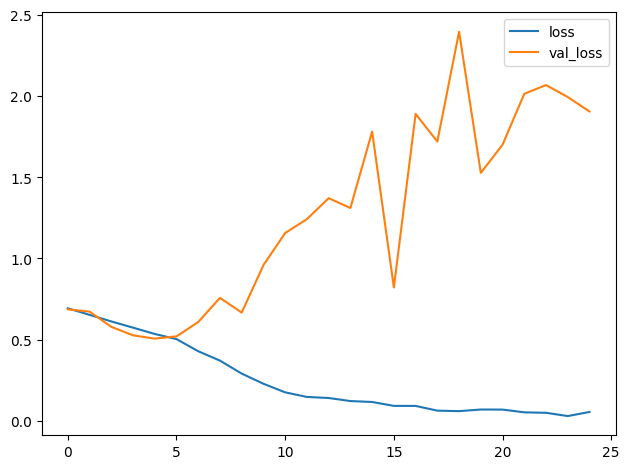

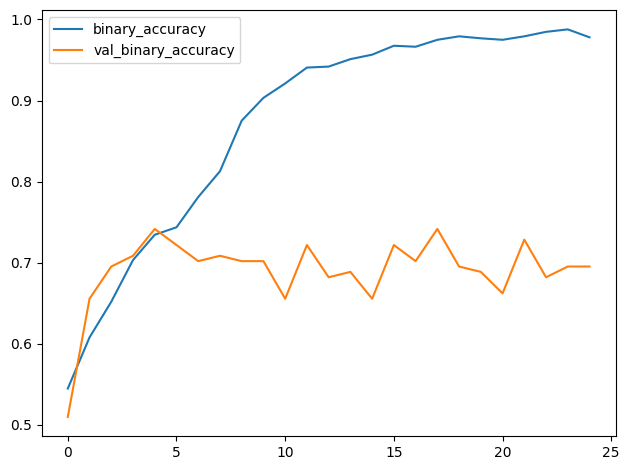

In [10]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### Q. *How would you interpret these training curves? Did this model improve upon the models from the lecture?*

Please explain your answer in the empty cell below.

Answer:
As you can see in the above grpahs, i see the training loss dropping and the validation losses are increasing which means that the training maybe over fitting. The drop out parameter of 0.2 maynot be sufficient and maybe we need to increase the drop out parameter to 0.5 (maybe ?)

## Take-Away

These exercises showed you how to design a custom convolutional network to solve a specific classification problem. Though most models these days will be built on top of a pretrained base, in certain circumstances a smaller custom convnet might still be preferable -- such as with a smaller or unusual dataset or when computing resources are very limited. As you saw here, for certain problems they can perform just as well as a pretrained model.

Next you'll learn a widely-used technique that can give a boost to your training data: **data augmentation**.

---
# 3. Data Augmentation 

In these exercises, you'll explore what effect various random transformations have on an image, consider what kind of augmentation might be appropriate on a given dataset, and then use data augmentation with the package label dataset to train a custom network.

Run the cell below to set everything up!

## 1) Explore Augmentation 

Uncomment a transformation and run the cell to see what it does. You can experiment with the parameter values too, if you like. (The `factor` parameters should be greater than 0 and, generally, less than 1.) Run the cell again if you'd like to get a new random image.

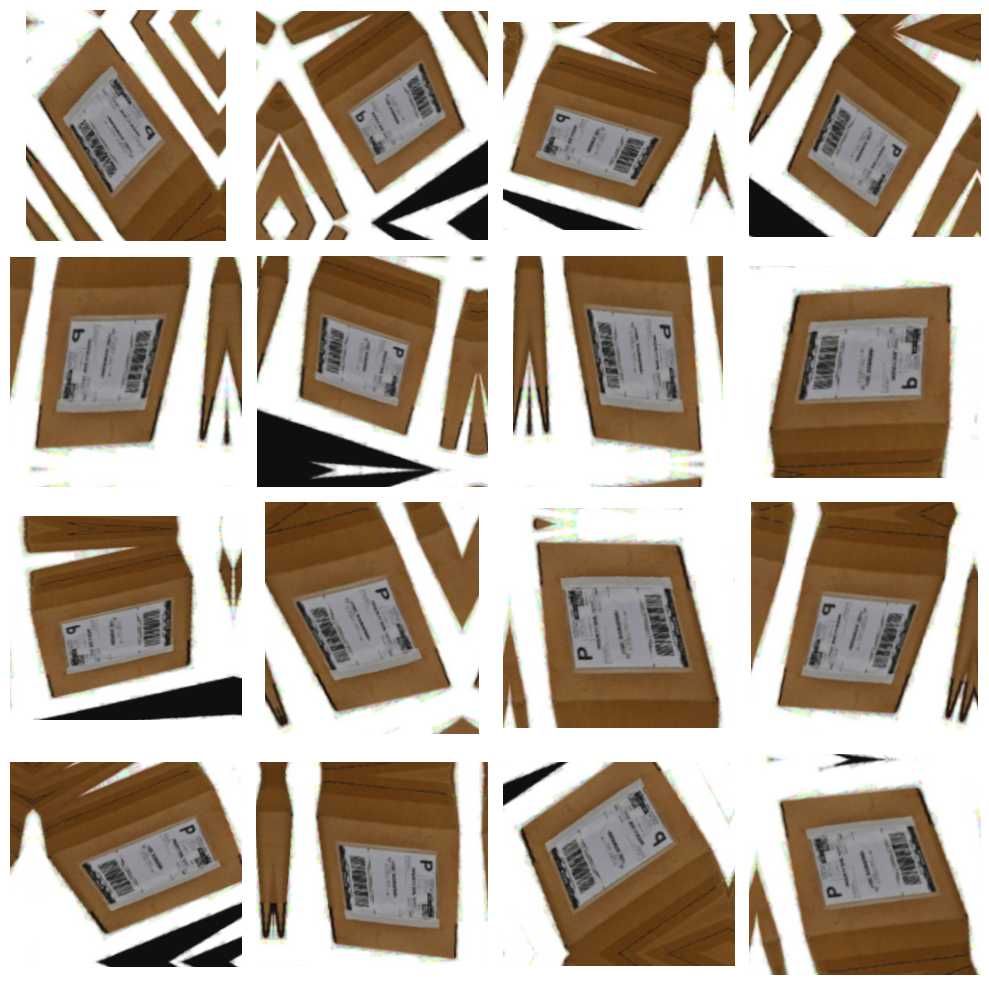

In [19]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    layers.RandomZoom(height_factor=0.3, width_factor=0.2),
    layers.RandomFlip(mode='horizontal'), # meaning, left-to-right
    layers.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    layers.RandomWidth(factor=0.15), # horizontal stretch
    layers.RandomRotation(factor=0.10),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_test.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

### Q: *Do the transformations you chose seem reasonable for the package label dataset?*

Please explain your answer in the empty cell below.

Answer: It does makes sense in some pictures. One is data augmentataion allows for generation of multiple training pictures to detect the label. HOwever it is also feasible that the boxes pictures may come in different shapes, sizes, and orientation in real world. However for the truck maybe flips maynot be necessary as there is no chance for the images in real world to have these images like this 

## 2) Appropriate Transformation

In this exercise, we'll look at a few datasets and think about what kind of augmentation might be appropriate. The point of this exercise is just to think about how a transformation might interact with a classification problem -- for better or worse.

The following dataset consists of images of containers classified by type of damage (rust, dent, hole). Below are a number of images from this dataset.

<figure>
<img src="https://i.imgur.com/VChFcg9.png" width=800, alt="Damage containers">
</figure>

### Q. *What kinds of transformations might be appropriate for this dataset?*

Please explain your answer in the empty cell below.

Answer:
Zoom - Yes as we can see more clearly the issues and then detect issue more accurately , H Flip - depends the accident site. if there is a change of vehicle overturned then a flip maybe necessary , V Flip - same as H flip depends on the context of the image received , Random width - strech maynot be a issue as most containers are standard sized and as long as the camera positions is fixed it maynot affect , Rotation - maynot be helpful as training on rotated images maynot be helpful , Translation - wont be helpful . However msot of transfomration depends on the context of the application of the problem  

The following dataset consists of camera stills of boxes on a conveyor belt. Below is a sample.

<figure>
<img src="https://i.imgur.com/rePAVZx.png" width=800, alt="Boxes on conveyor belts">
</figure>

### Q. *What kinds of transformations might be appropriate for this dataset?*

Please explain your answer in the empty cell below.

Answer: In this context, we can see that there most of the transformations are applicable as there is variations in box sizes, dimenison, label locatons can be multiple places, and along the converyer we can have the boxes rolling and taking different orientations. Thus transformations will help. 

## 3) Add Preprocessing Layers

Now you'll use data augmentation with a custom convnet similar to the one you built above. 

Add these preprocessing layers to the given model.

```
layers.RandomFlip(mode='horizontal'),
layers.RandomRotation(factor=0.10),
```

In [21]:
# YOUR CODE HERE: Add data augmentation pre-processing layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[224, 224, 3]),

    # Data Augmentation 
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.10),
    

    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'), #the higher filers is applied later as we want to exteact over max pooled images
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])


## 4) Train Model 

Now we'll train the model. Run the next cell to compile it with a loss and accuracy metric and fit it to the training set.

Epoch 1/25
1635/1635 [==============================] - 13s 7ms/step - loss: 0.7016 - binary_accuracy: 0.5242 - val_loss: 0.6937 - val_binary_accuracy: 0.4901
Epoch 2/25
1635/1635 [==============================] - 11s 7ms/step - loss: 0.6928 - binary_accuracy: 0.5193 - val_loss: 0.6920 - val_binary_accuracy: 0.5099
Epoch 3/25
1635/1635 [==============================] - 11s 7ms/step - loss: 0.6984 - binary_accuracy: 0.5291 - val_loss: 0.6880 - val_binary_accuracy: 0.4901
Epoch 4/25
1635/1635 [==============================] - 11s 7ms/step - loss: 0.6919 - binary_accuracy: 0.5180 - val_loss: 0.6948 - val_binary_accuracy: 0.4901
Epoch 5/25
1635/1635 [==============================] - 11s 7ms/step - loss: 0.6933 - binary_accuracy: 0.5193 - val_loss: 0.6948 - val_binary_accuracy: 0.4901
Epoch 6/25
1635/1635 [==============================] - 11s 7ms/step - loss: 0.6930 - binary_accuracy: 0.5131 - val_loss: 0.6949 - val_binary_accuracy: 0.4901
Epoch 7/25
1635/1635 [========================

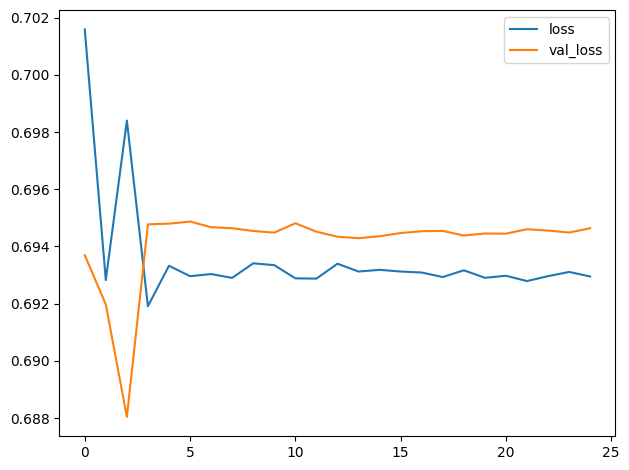

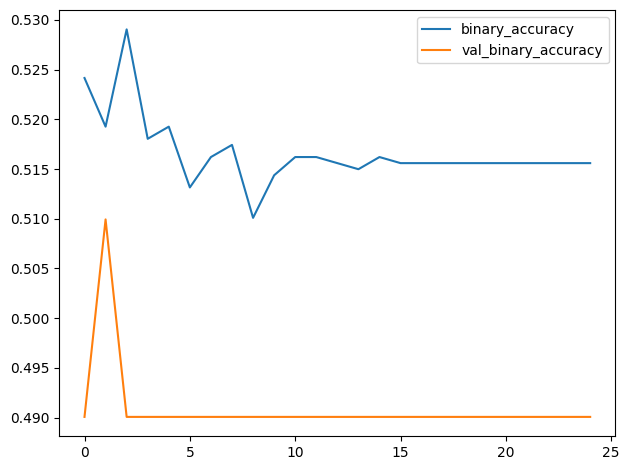

In [22]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### Q. *Examine the training curves. What there any sign of overfitting? How does the performance of this model compare to other models you've trained on this dataset?*

Please explain your answer in the empty cell below.

Answer: There is a good improvement as compared to others. I think the additon of transformation allowed the model to study better and then learn faster. This allowed the model to get a stable accuracy quickly and then settled for both training and validation data. This is not overtraining the data as well. Each transformed data kind of helps the model to learn more and better, and thus improves the overall accuracy of the model

## Take-Away

Data augmentation is a powerful and commonly-used tool to improve model training, not only for convolutional networks, but for many other kinds of neural network models as well. Whatever your problem, the principle remains the same: you can make up for an inadequacy in your data by adding in "fake" data to cover it over. Experimenting with augmentations is a great way to find out just how far your data can go!

# The End #

That's all for **Computer Vision** in SCM.256! Have fun applying your knowledge!